# The time-area method and the unit hydrograph

Author: Kristian Förster

Inspired by the paper *Demonstrating the "unit hydrograph" and flow routing processes involving active student participation – a university lecture experiment* (Schulz et al., 2018, published [here](https://www.hydrol-earth-syst-sci.net/22/2607/2018/)), which demonstrates the time-area method with active student participation, we developed an interactive version of this method utilizing Jupyter notebooks. This Jupyter notebook is part of the course materials of "Urban Hydrology" at Leibniz Universität Hannover.

Let's start with relevant imports and some defintions considering the flow direction of surface runoff. We consider the compass points N (North), NE (North-East), ...:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib import colors
import copy
import pandas as pd
from IPython import display
import os

# Definition of flow directions
E  =   1
SE =   2
S  =   3
SW =   4
W  =   5
NW =   6
N  =   7
NE =   8
O  =   9

`O` denotes the outlet. We then write a function that transforms our convention about the flow direction to vectors:

In [2]:
def get_vec(fd):
    ''' Transforms flow direction to vectors.
        
        arguments:
        fd: number that defines the flow direction
        
        returns:
        Unit vector representing the flow direction (list)
    '''
    if   fd == E:  return [ 1, 0]
    elif fd == SE: return [ 1, 1]
    elif fd == S:  return [ 0, 1]
    elif fd == SW: return [-1, 1]
    elif fd == W:  return [-1, 0]
    elif fd == NW: return [-1,-1]
    elif fd == N:  return [ 0,-1]
    elif fd == NE: return [ 1,-1]
    else: return [0,0]

This function expects a single flow direction and returns a vector. In order to apply this function to a 2D array, we provide another function that iterates over all rows and columns, repsectively:

In [3]:
def get_vec_array(array):
    ''' Transforms an array of flow direction categories to two arrays, 
        including the x- and y-components of the unit vectors
        
        arguments:
        array: array of flow direction
        
        returns:
        Two arrays with x- and y-component of the unit vectors of flow direction
    '''
    xs = np.zeros(array.shape)
    ys = np.zeros(array.shape)
    for ii in range(array.shape[0]):
        for jj in range(array.shape[1]):
            val = get_vec(array[ii,jj])
            xs[ii,jj] = val[1]
            ys[ii,jj] = val[0]
    return xs,ys

Since we need vectors for further compuations, the function `get_vec_array()` returns 2 2D arrays, representing the x and y compontents of the vectors, respectively. Another function `flow()` represents the core functionality of the time-area approach. As you can see, it is a recursive function which calls itself. This way, it starts at the outlet and goes up to the boundary of the watershed. By recursively sampling the flow path, flow units are routed to the corresponding downhill cells. Each call is a single flow step (cell to cell) applied to the entire grid. 

In [4]:
def flow(fd, row, col,array=None,init_val=0,first_call=True):
    ''' Flow against flow path, operates recursively
        
        arguments:
        fd: array of flow direction
        row: row index of of the cell for which computation is done
        col: column index of of the cell for which computation is done
        array: array that represents the flow in each grid cell
        init_val: the initial value (rain) associated to the cell
        first_call: bool value indicating if the function is called
                    for the first time
        
        returns:
        outflow: runoff at the outlet in the current time step
        array: updated array that represents the flow in each grid cell
    '''
    if first_call:
        # if no array provided create a new one, else create a copy
        if array is None:
            array = np.zeros(fd.shape)
        else:
            array = copy.deepcopy(array)
    inflow=0
    outflow = array[row,col]
    array[row,col]=init_val
    for dr in [-1,0,1]:
        for dc in [-1,0,1]:
            if dr == 0 and dc == 0: continue
            r = row+dr
            c = col+dc
            if r >= 0 and r < fd.shape[0] and c >= 0 and c < fd.shape[1]:
                dc2,dr2 = get_vec(fd[r,c])
                if dc2==-dc and dr2==-dr:
                    # call function itself (go upstream)
                    inflow_rc,_=flow(fd,r,c,array,init_val=init_val,first_call=False)
                    inflow+=inflow_rc
    array[row,col]+=inflow
    return outflow,array

In order to control the step-wise call of this function, we define another function, called `simulation`. This function provides time series of the grid's outflow at the outlet `O` as well as a list of maps. These maps show the flow for each time step.

In [5]:
def get_catchment_size(flowdir):
    '''Returns the catchment size from flow direction map
       
       arguments:
       flowdir: array of flow direction (2d map)
       
       returns:
       catchment size (number of cells) (float)
    
    '''
    return np.count_nonzero(flowdir)

def simulation(flowdir, rainfall=[1], max_it = 20, verbose=True):
    ''' This function looks for the outlet, prepares and runs the simulation,
        returns list of outflow values and list of maps
        
        arguments:
        flowdir: array of flow direction (2d map)
        rainfall: time series of rainfall input (list)
        max_it: maximum number of iterations (increase if results are incomplete)
        verbose: prints messages to the screen
        
        returns:
        list_ouflow: time series of runoff at the outlet (list)
        list_arrays: set of array which represent the runoff for each time step
                     in each cell
        '''
    size = get_catchment_size(flowdir)
    if verbose:
        print('Catchment size = %i grid cells...' % size)
    # find outlet
    outlet_row,outlet_col = np.where(flowdir==O)
    has_outlet = False
    if len(outlet_row) == 1:
        out_row = outlet_row[0]
        out_col = outlet_col[0]
        has_outlet = True
    if not has_outlet:
        raise 'No outlet or to many outlets exception'
    if verbose:
        print('Outlet found in row %i and column %i' % (outlet_row, outlet_col))
    
    # initialize simulation
    list_outflow = list()
    list_arrays  = list()
    simulation = True
    i = 0
        
    # do the simulation
    while simulation:
        if i == 0:
            outflow,array=flow(flowdir,out_row,out_col, init_val=rainfall[0])
        else:
            if i < len(rainfall):
                r = rainfall[i]
            else:
                r = 0
            outflow,array=flow(flowdir,out_row,out_col,array,init_val=r)
        if verbose: print('t=%i'%i)
        list_outflow.append(outflow)
        list_arrays.append(array)
        if (i>0 and outflow==0) or i >= max_it:
            break
        i+=1
    if verbose:
        print('Simulation completed. Rain input=%i, outflow=%i.' % \
          (np.sum(rainfall)*size, np.sum(list_outflow)))
    # create array of results
    return list_outflow, list_arrays

Finally, we define a function that provides basic plot functionality to visualize the results (the first three lines are only relevant if you plan to export animations as video file):

In [42]:
ffmpeg = '/Users/kristianfoerster/Documents/ffmpeg'
plt.rcParams['animation.ffmpeg_path'] = ffmpeg
save_anim = os.path.exists(ffmpeg)

def animation(flowdir, list_outflow, list_arrays, rainfall=None, 
              plot_lines=None, normalize=False, to_file=None,
              interval=250):
    ''' Function to visualize the simulations results
    
        arguments:
        flowdir: the flow direction grid (array)
        list_outflow: time series of runoff at the outlet (list), which
                      is provided by simulation()
        list_arrays: set of array which represent the runoff for each time step
                     in each cell, is provided by simulation()
        rainfall: list of rainfall (optional time series)
        plot_lines: optional argument for line plotting (list including 2 lists, x and y)
        normalize: whether to normalize output time series (i.e., sum equals 1) (bool)
        interval: milliseconds between frames
    '''
    def animate(j):
        # create mesh grids which include row / col numbers, respectively
        rr,cc = np.meshgrid(np.arange(flowdir.shape[0]),np.arange(flowdir.shape[1]), indexing='ij')
        # transform flow direction categories to vectors
        vy, vx = get_vec_array(flowdir)

        # fontsize
        fs = 16
        plt.rcParams.update({'font.size': fs})
        
        # plotting
        outflows = np.array(list_outflow)

        if normalize:
            c = 1. / get_catchment_size(flowdir)
            ystr = ' (Normalized)'
        else:
            c = 1.
            ystr = ''

        array = copy.deepcopy(list_arrays[j])
        invalid = array==0.
        vx2 = copy.deepcopy(vx)
        vy2 = copy.deepcopy(vy)
        vx2[invalid]=np.nan
        vy2[invalid]=np.nan
        array[invalid]=np.nan
        mask=(flowdir>0).astype(float)
        mask[mask==0]=np.nan

        ax = plt.subplot2grid((6,15), (0,0), colspan=6, rowspan=6)
        ep = patches.Rectangle((-0.5,-0.5), flowdir.shape[1], flowdir.shape[0], 
                               color='#f0f0f0', hatch='//', fill=None, zorder=-10)
        ax.add_patch(ep)
        cmapw = colors.ListedColormap(['white'])
        im0=ax.imshow(mask,cmap=cmapw)
        im=ax.imshow(array*c, vmin=0, vmax=np.max(outflows*c), cmap=plt.get_cmap('Blues'))
        if np.count_nonzero(~np.isnan(vx2)) > 1 or np.count_nonzero(~np.isnan(vy2)) > 1:
            ax.quiver(cc,rr,vx2,-vy2,zorder=3)
        fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75)
        ax.set_xlabel('x', fontsize=fs)
        ax.set_ylabel('y', fontsize=fs)
        ax.set_xticks(np.arange(0, flowdir.shape[1]))
        ax.set_yticks(np.arange(flowdir.shape[0],0,-1)-1)
        ax.set_xticks(np.arange(0.5, flowdir.shape[1],1), minor=True)
        ax.set_yticks(np.arange(flowdir.shape[0],0,-1)-0.5, minor=True)
        ax.set_title('t=%i, Runoff=%.1f' % (j, list_outflow[j]), fontsize=fs)
        plt.grid(which='minor', linestyle=':',zorder=0)

        maxy = np.max(outflows)*1.2*c
        ax2 = plt.subplot2grid((6,15), (0,9), colspan=6, rowspan=2)
        ax2.set_xlim(0,len(outflows))
        ax2.set_ylim(0,maxy)
        ax2.set_xlabel('Time', fontsize=fs)
        ax2.set_ylabel('Runoff'+ystr, fontsize=fs)
        ax2.set_title('Runoff time series', fontsize=fs)
        plt.grid('on', linestyle=':')
        ax2.plot(np.arange(0,j+1),outflows[0:j+1]*c)
        if rainfall is not None:
            ax21 = ax2.twinx()
            ax21.bar(np.arange(0,len(rainfall))[0:j+1], rainfall[0:j+1], 
                     width=1, color='#31a354',edgecolor='#636363')
            ax21.set_ylim(0,np.max(rainfall)*4)
            ax21.invert_yaxis()
            ax21.set_ylabel('Rainfall', fontsize=fs)
        if plot_lines is not None:
            if len(plot_lines)==2:
                ax.plot(plot_lines[0], plot_lines[1], '-r')
        del array,vx2,vy2
        
    fig = plt.figure(figsize=(12,5))
    gridspec.GridSpec(6,15)
    plt.tight_layout()
        
    anim = FuncAnimation(fig, animate, frames=len(list_outflow), interval=interval)
    if 'save_anim' in globals():
        if save_anim:
            video = anim.to_html5_video()
            html = display.HTML(video)
            display.display(html)
            plt.close()

    plt.draw()
    plt.pause(15)
    plt.show()

Let's test our time-area diagram approach to model the flow of an eastwards sloping plane which drains into a southward flowing channel (n.b. we neither distinguish between plane and channel nor consider the slope of the cells). Based on our definitions of flow direction, we create a 2D `numpy` `array` of arbitrary rows and columns dimension:

In [8]:
flowdir = np.array([[ 0, 0, 0, S, 0],
                    [ E, E, E, S, 0],
                    [ E, E, E, S, 0],
                    [ E, E, E, S, 0],
                    [ 0, 0, 0, O, 0]])

Now, we can specify the rainfall input as list (please note that we do not specify the unit here, you could provide the numbers in millimeters or any other hydrological volume/mass unit; runoff is provided in the same way):

In [9]:
rainfall = [1,5,2,1]

Zero means that these cells are not considered in the model. `O` is the outlet of the model with the rainfall time series (`rainfall`). Now we can run the model and save the results (outflow time series and flow per cell maps):

In [33]:
list_outflow, list_arrays = simulation(flowdir, rainfall=rainfall)

Catchment size = 14 grid cells...
Outlet found in row 4 and column 3
t=0
t=1
t=2
t=3
t=4
t=5
t=6
t=7
t=8
t=9
t=10
t=11
Simulation completed. Rain input=126, outflow=126.


The output tells us some details about the simulation (location of the outlet and number of time step). Let's have a closer look on the results:

In [11]:
list_outflow

[0.0, 1.0, 6.0, 9.0, 16.0, 24.0, 30.0, 22.0, 13.0, 4.0, 1.0, 0.0]

The previous line is the time series. A better visualization (including both time series and maps) is prvided by the `plot_results()` function:

In [43]:
animation(flowdir, list_outflow, list_arrays, rainfall, interval=500)

<Figure size 432x288 with 0 Axes>

The maps for each time step along with the time series show how surface runoff is routed downhill and how superposition work. Check other flow direction maps! What happens if we change the flow direction map? We now demonstrate the theory of the unit hydrograph, which is related to the hydrological response of the system forced by one unit of rainfall. We can re-run the model with a single rainfall input within one time step. Note that the simulation now has less time steps!

In [44]:
# same flow direction grid but only one rainfall unit
list_outflow_uh, list_arrays = simulation(flowdir, rainfall=[1])

Catchment size = 14 grid cells...
Outlet found in row 4 and column 3
t=0
t=1
t=2
t=3
t=4
t=5
t=6
t=7
t=8
Simulation completed. Rain input=14, outflow=14.


We now see that a rainfall of 1 yields a runoff total of 14, given a catchment size of 14. Recall the assumptions underlying the unit hydrograph theory:
* *Stationarity (invariance)*: The response behaviour of the system is *independent* of the time. 
* *Proportionality*: If the input is multiplied by a constant *c* the new output can be obtained by multiplying the original output with the same constant *c*.
* *Superposition*: Superposition of *two* **input signals** is equal to the sum of the *two* specific **output signals**.
* *Linearity*: Just the combination of proportionality & superposition.

The `unit_hydro()` function helps to apply these assumptions to derive time series out of the response of a unit of rainfall. Two arguments are required:
* the rainfall time series as list (i.e. `rainfall`) and
* the unit hydrograph (i.e., `list_outflow_uh`)

The function returns a table. The columns represent the hydrological repsonse of each rainfall input (i.e., the members of list `rainfall`). 

In [45]:
def unit_hydro(rainfall, unit_hydrograph):
    ''' Unit hydrograph function which computes the hydrological response
        of each rainfall input applied to a unit hydrograph
        
        arguments:
        rainfall: rainfall time series (list)
        unit_hydrograph: the hydrological response of the unit hydrograph
                         (list)
        
        returns:
        df.T: dataframe including the hydrological response of each ordinate
              in rainfall
    '''
    list_comp = list()
    list_str = list()
    # iterate over all rainfall elements
    for i,r in enumerate(rainfall):
        list_str.append('TS%00i' % i)
        tsi = r * np.array(unit_hydrograph)
        # shift time begin of hydrological repsonse
        if i > 0:
            start = np.array([0]*i).astype(float)
            tsii = np.concatenate((start, tsi))
        else:
            tsii = tsi
        list_comp.append(tsii)

    df = pd.DataFrame(data=list_comp, index=list_str)
    
    return df.T

The next lines show how this function works in principle (for instance, TS0 is the response to the first rainall intervall, TS1 to the second and so on):

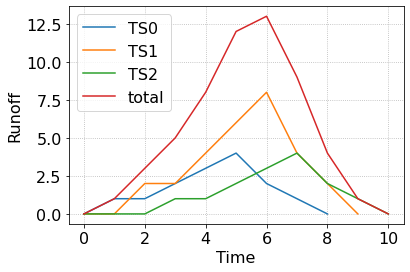

In [46]:
table = unit_hydro([1,2,1], list_outflow_uh)
table.plot()
table.sum(axis=1).plot(label='total')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Runoff')
plt.grid('on', linestyle=':')